In [1]:
import math
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import datetime
from datetime import date
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [530]:
stock = input("Enter Ticker")

In [531]:
today = date.today()
yesterday = today - datetime.timedelta(days=1)
tomorrow = today + datetime.timedelta(days=1)

In [532]:
Stock = wb.DataReader(stock, data_source='yahoo', start='2018-1-1', end=today)
print(stock)

ZM


In [533]:
Stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-04-18,66.000000,60.320999,65.000000,62.000000,25764700,62.000000
2019-04-22,68.900002,59.939999,61.000000,65.699997,9949700,65.699997
2019-04-23,74.168999,65.550003,66.870003,69.000000,6786500,69.000000
2019-04-24,71.500000,63.160000,71.400002,63.200001,4973500,63.200001
2019-04-25,66.849998,62.599998,64.739998,65.000000,3863300,65.000000


In [557]:
data = Stock.filter(['Adj Close'])

dataset = data.values

#Identify 80% of the data
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

212

In [558]:
#scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [571]:
#create training data, 80% of the data retrieved
train_data = scaled_data[0:training_data_len, :]
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [537]:
#Convert the x_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train) 

In [538]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [539]:
#Build Long Short-Term Memory model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [540]:
#Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [541]:
#Train the model
model.fit(X_train, y_train, epochs=100)
# model.fit(X_train, y_train, epochs=1)

Epoch 1/100
152/152 [==============================] - 7s 49ms/step - loss: 0.0193
Epoch 2/100
152/152 [==============================] - 2s 11ms/step - loss: 0.0090
Epoch 3/100
152/152 [==============================] - 2s 11ms/step - loss: 0.0044
Epoch 4/100
152/152 [==============================] - 2s 12ms/step - loss: 0.0051
Epoch 5/100
152/152 [==============================] - 2s 11ms/step - loss: 0.0031
Epoch 6/100
152/152 [==============================] - 2s 12ms/step - loss: 0.0031
Epoch 7/100
152/152 [==============================] - 2s 12ms/step - loss: 0.0026
Epoch 8/100
152/152 [==============================] - 2s 12ms/step - loss: 0.0026
Epoch 9/100
152/152 [==============================] - 2s 12ms/step - loss: 0.0024
Epoch 10/100
152/152 [==============================] - 2s 12ms/step - loss: 0.0022
Epoch 11/100
152/152 [==============================] - 2s 12ms/step - loss: 0.0022
Epoch 12/100
152/152 [==============================] - 2s 12ms/step - loss: 0.0020
E

In [542]:
#Add testing data of values before 80% of the data
test_data = scaled_data[training_data_len-60: , :]

X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))

In [545]:
#Get the models predicted price values
predictions = model.predict([X_test], verbose=0)

predictions = scaler.inverse_transform(predictions)

In [546]:
print(f'Loss: {model.evaluate(X_test, y_test)}')

53/53 [==============================] - 1s 22ms/step
Loss: 17290.579488502357


In [547]:
#(RMSE) how accurate model predicts the response, low values of RMSE indicate a better fit
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

0.9669988380288178

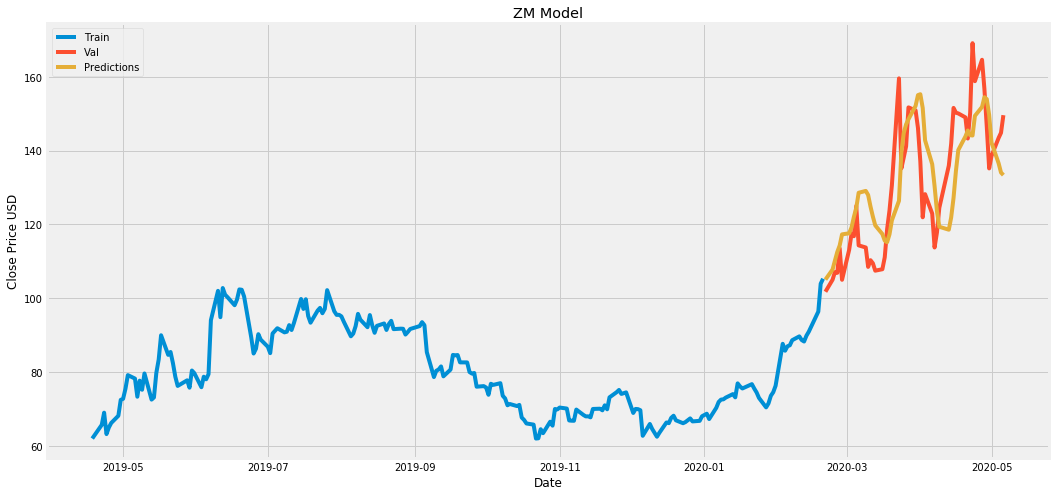

In [554]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title(f'{stock} Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train["Adj Close"])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val','Predictions'], loc='top center')
# plt.savefig(f"{stock}_model-100epochs.jpg")

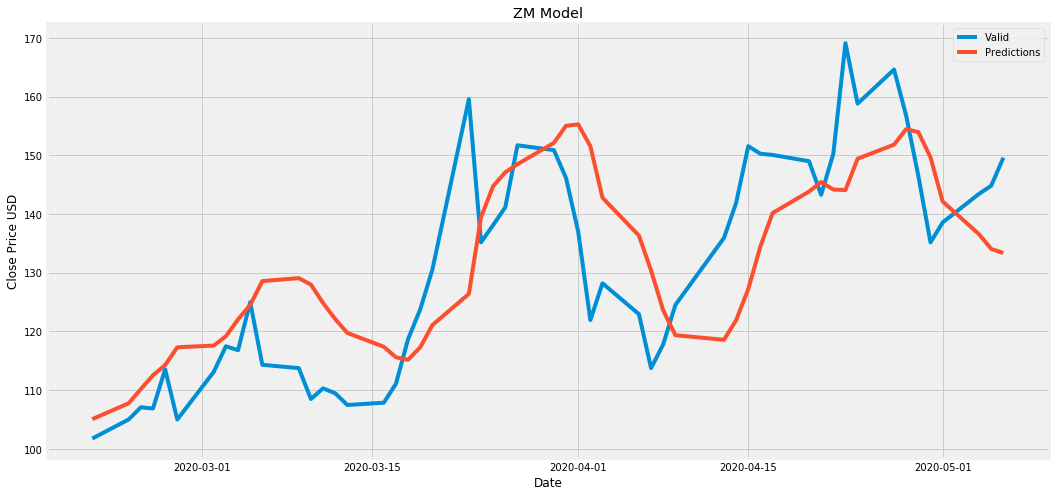

In [555]:
plt.figure(figsize=(16,8))
plt.title(f'{stock} Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Valid','Predictions'], loc='top center')
# plt.savefig(f"{stock}_predictions-100epochs.jpg")

In [550]:
#Show valid and predicted prices
valid.tail(10)

,Adj Close,Predictions
Date,,
2020-04-23,169.089996,144.084412
2020-04-24,158.800003,149.411713
2020-04-27,164.600006,151.808441
2020-04-28,156.720001,154.455994
2020-04-29,146.479996,153.941544
2020-04-30,135.169998,149.653839
2020-05-01,138.559998,142.136490
2020-05-04,143.440002,136.545868
2020-05-05,144.820007,134.042938


In [551]:
Quote = wb.DataReader(stock, data_source='yahoo', start='2018-1-1', end=yesterday)

new_df = Quote.filter(['Adj Close'])

#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

#Scale data between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

x_test = []
x_test.append(last_60_days_scaled)

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred_price = model.predict(x_test, verbose=2)

pred_price = scaler.inverse_transform(pred_price)
print(f'Predicted Price for "{stock}" {today}: {pred_price[:, 0][0]}')

Predicted Price for "ZM" 2020-05-06: 133.35906982421875


In [552]:
print(f"Actual Closing price for '{stock}' {today}: {wb.DataReader(stock, data_source='yahoo', start=today, end=today)['Adj Close'][0]}")

Actual Closing price for 'ZM' 2020-05-06: 149.58999633789062


In [553]:
Quote2 = wb.DataReader(stock, data_source='yahoo', start='2018-1-1', end=today)

new_df = Quote2.filter(['Adj Close'])

#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

#Scale data between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

x_test = []
x_test.append(last_60_days_scaled)

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred_price = model.predict(x_test)

pred_price = scaler.inverse_transform(pred_price)
print(f'Predicted Price for "{stock}" {tomorrow}: {pred_price[:, 0][0]}')

Predicted Price for "ZM" 2020-05-07: 134.64288330078125
